# Random Forest code


In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings
#import plotly.graph_objs as go #visualization
import matplotlib.pyplot as plt#visualization
import seaborn as sns #visualization
#import plotly.offline as py #visualization
#import plotly.tools as tls #visualization
#import plotly.figure_factory as ff #visualization

from sklearn.metrics import accuracy_score

In [68]:
#read train data
train = pd.read_csv('../data/generated/train_eng9.csv')
test = pd.read_csv('../data/generated/test_eng9.csv')

#extract labels
train_y = train['label']
#remove labels from train
train.drop(columns=['label'], inplace=True)

print(train.values.shape)
print(train_y.values.shape)
train.head(5)

(24840, 235)
(24840,)


,Cat_Friday,Cat_FridayCat_Hour_bucket_0,Cat_FridayCat_Hour_bucket_1,Cat_FridayCat_Hour_bucket_2,Cat_FridayCat_Hour_bucket_3,Cat_Hour_bucket_0,Cat_Hour_bucket_1,Cat_Hour_bucket_2,Cat_Hour_bucket_3,Cat_MailType_multipart/alternative,...,sender_chars_in_subject_std,sender_count,sender_depth,sender_images_mean,sender_images_std,sender_urls_mean,sender_urls_std,timezone_2,urls,urls_2
0,0,0,0,0,0,1,0,0,0,0,...,25.912548,1676.0,1,9.502387,11.356555,79.059069,81.329729,0.00,0,0
1,0,0,0,0,0,0,1,0,0,1,...,26.823572,1285.0,2,12.677821,12.469546,54.352529,39.501797,0.00,44,1936
2,0,0,0,0,0,1,0,0,0,1,...,37.100218,1241.0,0,7.725222,5.541580,84.025786,39.562621,64.00,110,12100
3,0,0,0,0,0,0,0,1,0,1,...,26.440099,6313.0,4,0.442737,3.459240,7.043561,76.700633,30.25,0,0
4,0,0,0,0,0,0,1,0,0,1,...,21.377212,47.0,1,16.680851,9.923854,99.234043,53.804482,0.00,49,2401


Build a normalize that will apply standard scaler and PCA if required

In [69]:
def NormalizeData(train, CVorTest, PCA_comp = None, ScaleCat = False):
    '''
    Normalize data using a standard scaler
    train:
        dataframe that will be use to fit and transformed by the scaler and PCA
    CVorTest:
        dataframe that will be transformed the scaler and PCA
    PCA_comp:
        Number of PCA components to keep, if None, PCA not applied
    ScaleCat:
        Scale or not the categorical columns with the standard scaler
    '''
    
    sc = StandardScaler()
    
    if ScaleCat:
        scale_columns = train.columns
    else:
        scale_columns = [col for col in train.columns[~train.columns.str.startswith('Cat_')]]
          
    #perform feature scaling    
    print('Nb columns to scale :', len(scale_columns))
    train.loc[:, scale_columns] = sc.fit_transform(train.loc[:, scale_columns]) 
    CVorTest.loc[:, scale_columns] = sc.transform(CVorTest.loc[:, scale_columns]) 
    
    if PCA_comp is None:
        return train.values, CVorTest.values
    
    pca = PCA(PCA_comp)
    train = pca.fit_transform(train)
    CVorTest = pca.transform(CVorTest)
    
    return train, CVorTest

In [70]:
#Normalize Data
train, test = NormalizeData(train, test, None, False)

Nb columns to scale : 138


In [21]:
#Perfrom Random Forest
n_samples = train.shape[0]
neigh = RandomForestClassifier(min_samples_split= 2, n_estimators=900, max_depth= 300, random_state=0, criterion = 'gini', bootstrap= False, warm_start= True, class_weight= None)
neigh.fit(train, train_y)
pred_y = neigh.predict(test)

#Do Cross Validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
RF_model = cross_val_score(neigh, train, train_y, cv=cv, scoring='f1_macro')  
RF_model.mean()

0.9650400619608938

In [29]:
# Parameter tuning
# Applying Grid Search CV to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators':[10, 900], 'max_depth':[1, 300]}] 
grid_search = GridSearchCV(estimator = neigh,
                          param_grid = parameters,
                          scoring = 'f1_macro',
                          cv = cv)
grid_search = grid_search.fit(train, train_y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy, best_parameters)

/Users/philibert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philibert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philibert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philibert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/phili

0.9635222093157081 {'max_depth': 300, 'n_estimators': 900}


In [6]:
## Save results to submission file
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("RF__submission.csv", index=True, index_label='Id')
pred_y.shape

(10647,)

## Features importance

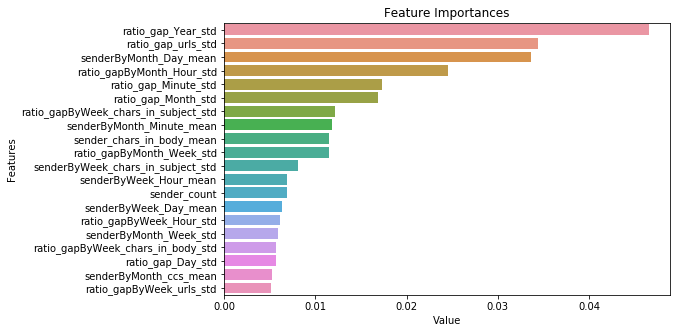

In [75]:
df_train = pd.read_csv('../data/generated/train_eng.csv')

feature_imp = pd.DataFrame(sorted(zip(neigh.feature_importances_,df_train.columns)), columns=['Value','Features'])

plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.show()